In [1]:
import argparse
import gzip
import json
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from utils import read_fastq

Parse arguments.

In [2]:
# with open('arguments.json', 'r') as f:
#     unparsed_args = json.load(f)

unparsed_args = ['--sample', 'Sahu_DNA_rep1']

parser = argparse.ArgumentParser()
parser.add_argument("--sample", help="Sample name")
args = parser.parse_args(unparsed_args)

Define file locations

In [ ]:
CUTADAPT_LOG = "output/logs/cutadapt"
PAIR = "output/pair"
PAIR_LOG = "output/logs/pair"
CLUSTER = "output/clustered"
CLUSTER_LOG = "output/logs/starcode"
COUNT = "output/counts"
COUNT_LOG = "output/logs/count"

Get cutadapt statistics.

In [3]:
with open(f"{CUTADAPT_LOG}/{args.sample}_cutadapt.log", 'r') as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    if line[:15] == "=== Summary ===":
        summary_start = i
        break

print("".join(lines[summary_start:summary_start + 11]))

=== Summary ===

Total read pairs processed:         19,939,964
  Read 1 with adapter:              19,773,307 (99.2%)
  Read 2 with adapter:              19,748,833 (99.0%)

== Read fate breakdown ==
Pairs that were too short:             188,991 (0.9%)
Pairs that were too long:              363,518 (1.8%)
Pairs discarded as untrimmed:                0 (0.0%)
Pairs written (passing filters):    19,387,455 (97.2%)



Get length distribution of too short and too long reads.

In [4]:
def get_paired_fastq_lengths(r1_fastq_fp, r2_fastq_fp, find_min=True):
    lengths = []
    with gzip.open(r1_fastq_fp, 'rt') as f_r1, gzip.open(r2_fastq_fp, 'rt') as f_r2:
        r1_reader = read_fastq(f_r1, skip_blank=False)
        r2_reader = read_fastq(f_r2, skip_blank=False)
        for r1, r2 in zip(r1_reader, r2_reader):
            header_diff = sum(i != j for i, j in zip (r1[0], r2[0]))
            # headers should only differ in one position (read 1 vs 2)
            if header_diff > 1:
                raise ValueError(f"Header IDs do not match: {r1[0]} and {r2[0]}")
            if find_min:
                lengths.append(min(len(r1[1]), len(r2[1])))
            else:
                lengths.append(max(len(r1[1]), len(r2[1])))
    return lengths

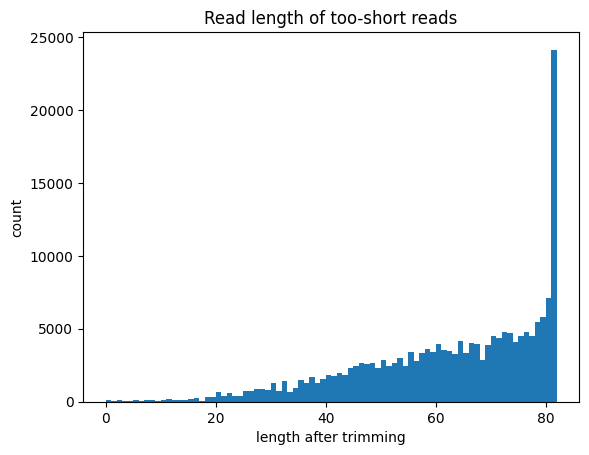

In [12]:
too_short = get_paired_fastq_lengths(f"{CUTADAPT_LOG}/{args.sample}_short_1.fastq.gz", f"{CUTADAPT_LOG}/{args.sample}_short_2.fastq.gz")
plt.hist(too_short, bins=range(min(too_short), max(too_short) + 1))
plt.title("Read length of too-short reads")
plt.xlabel("length after trimming")
plt.ylabel("count")
plt.show()

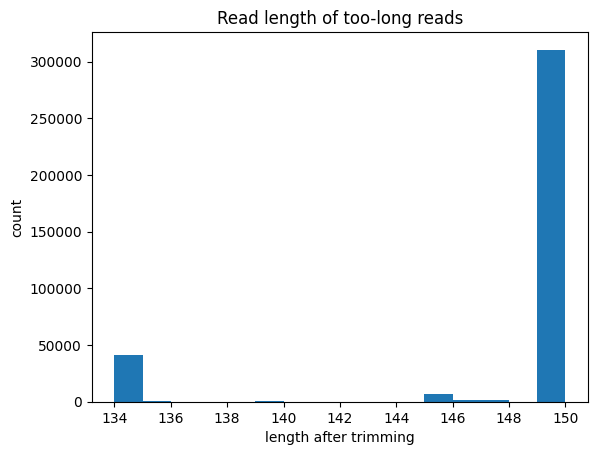

In [13]:
too_long = get_paired_fastq_lengths(f"{CUTADAPT_LOG}/{args.sample}_long_1.fastq.gz", f"{CUTADAPT_LOG}/{args.sample}_long_2.fastq.gz", find_min=False)
plt.hist(too_long, bins=range(min(too_long), max(too_long) + 1))
plt.title("Read length of too-long reads")
plt.xlabel("length after trimming")
plt.ylabel("count")
plt.show()

Analyze sequences thrown out during pairing.

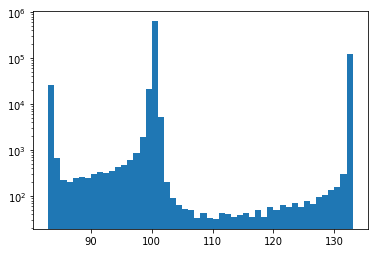

In [ ]:
lengths = [len(seq) for seq in df['seq']]
plt.hist(lengths, bins=range(83, 134))
plt.yscale('log')
plt.show()